In [6]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-21 10:19:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-08-21 10:19:19 (16.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [8]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-08-21 10:19:20--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.003s  

2023-08-21 10:19:20 (173 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [9]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [14]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
#BakeOffFriends #GBBO 'The one with the mudslide and the guy with the hat'

---

Target: 0 (not real disaster)
Text:
Spent too many hours sinking into the wonderfully created worlds of Mafia and Mafia II in my life. Excited for another installment.

---

Target: 0 (not real disaster)
Text:
ng2x5 mhtw4fnet

Watch Michael Jordan absolutely destroy this meme-baiting camper - FOXSportscom

---

Target: 1 (real disaster)
Text:
VIDEO: 'We're picking up bodies from water': Rescuers are searching for hundreds of migrants in the Mediterran... http://t.co/ZFWMjh6SLh

---

Target: 0 (not real disaster)
Text:
@ABCNews24 @PeterDutton_MP 
He also told you....No-one has drowned in the last 2 years &amp; 1200 had under Labor. But let's not mention that..

---



In [15]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [16]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [17]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [19]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Red Faction: Armageddon  (Microsoft Xbox 360 2011) - Full read by eBay http://t.co/ypbVS1IJya http://t.co/9dFLv6ynqr      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 368,    1,  443, 5126, 2217, 6328, 1564,  120,  193,   18,  462,
           1,    1,    0,    0]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [26]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
http://t.co/qr3YPEkfOe 
Seems they declared war against government..      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00080876,  0.00076435,  0.00195082, ...,  0.02274254,
         -0.01362888,  0.04300663],
        [-0.0459756 , -0.00891011, -0.01136775, ...,  0.04638099,
          0.00679036, -0.03201335],
        [ 0.02987565, -0.01967722, -0.0015594 , ..., -0.01892482,
         -0.01885488, -0.04562559],
        ...,
        [-0.01907327,  0.04786598,  0.01433653, ..., -0.01058414,
         -0.02940842,  0.0157895 ],
        [-0.01907327,  0.04786598,  0.01433653, ..., -0.01058414,
         -0.02940842,  0.0157895 ],
        [-0.01907327,  0.04786598,  0.01433653, ..., -0.01058414,
         -0.02940842,  0.0157895 ]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.00080876,  0.00076435,  0.00195082,  0.04705859, -0.02164182,
        0.02771619, -0.04816293, -0.03705133, -0.01488881, -0.01365606,
        0.02912958,  0.01971035, -0.03002883, -0.02611872, -0.02888643,
       -0.02615952,  0.03762216,  0.02048541,  0.03484507, -0.0189908 ,
        0.01257453,  0.03920424, -0.01447983, -0.03801637, -0.04983976,
       -0.04706639,  0.04319033, -0.00118073, -0.00727765, -0.04417669,
       -0.00585073,  0.02087981, -0.0481055 , -0.03766052, -0.03445778,
       -0.03103224,  0.01847633, -0.00090758, -0.02660918, -0.04090194,
        0.04147681, -0.01565559,  0.00187807, -0.02645092, -0.02438905,
       -0.03506272, -0.03080602,  0.03573285, -0.04946213,  0.0476316 ,
        0.04858083,  0.04501367, -0.01833708, -0.0182807 , -0.04537631,
       -0.03976773,  0.00203488,  0.04963366,  0.04227543,  0.02294538,
        0.0021114 , -0.02419741,  0.01299125,  0.00375741,  0.01771149,
        0.035434

**Model 0: Getting a baseline**

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

**Model 1: A simple dense model**

In [33]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=8,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230821-101922
Epoch 1/8
215/215 [==============================] - 17s 64ms/step - loss: 0.6108 - accuracy: 0.6892 - val_loss: 0.5368 - val_accuracy: 0.7559
Epoch 2/8
215/215 [==============================] - 6s 28ms/step - loss: 0.4420 - accuracy: 0.8189 - val_loss: 0.4694 - val_accuracy: 0.7822
Epoch 3/8
215/215 [==============================] - 2s 11ms/step - loss: 0.3472 - accuracy: 0.8606 - val_loss: 0.4589 - val_accuracy: 0.7887
Epoch 4/8
215/215 [==============================] - 2s 9ms/step - loss: 0.2858 - accuracy: 0.8914 - val_loss: 0.4636 - val_accuracy: 0.7900
Epoch 5/8
215/215 [==============================] - 2s 10ms/step - loss: 0.2389 - accuracy: 0.9120 - val_loss: 0.4758 - val_accuracy: 0.7874
Epoch 6/8
215/215 [==============================] - 2s 7ms/step - loss: 0.2027 - accuracy: 0.9279 - val_loss: 0.4984 - val_accuracy: 0.7861
Epoch 7/8
215/215 [==============================] - 3s 13ms/step - lo

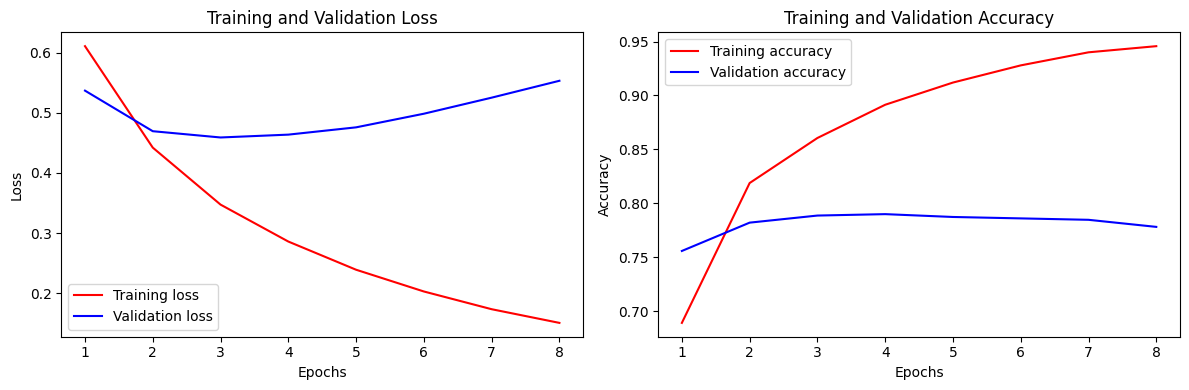

In [35]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_1_history.history['loss']
val_loss = model_1_history.history['val_loss']
train_accuracy = model_1_history.history['accuracy']
val_accuracy = model_1_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.5532 - accuracy: 0.7782


[0.5532391667366028, 0.778215229511261]

In [38]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.03232901,  0.03871285,  0.02827551, ..., -0.02364781,
         -0.04379383,  0.00206513],
        [-0.00602178,  0.00175881,  0.00778039, ...,  0.0189517 ,
         -0.01969863,  0.03714313],
        [-0.034624  , -0.02907014,  0.03319977, ...,  0.01361277,
          0.00058582,  0.00565536],
        ...,
        [-0.01608976,  0.01493366,  0.01080758, ..., -0.0159192 ,
         -0.0399251 ,  0.04811979],
        [-0.08347985, -0.03232941,  0.02793101, ..., -0.02917487,
         -0.03374297, -0.0664802 ],
        [-0.05636792, -0.13793725,  0.06154353, ..., -0.13874058,
         -0.13369735, -0.12454074]], dtype=float32)>]

In [39]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [40]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.4099708 ],
       [0.72033155],
       [0.99944097],
       [0.08734478],
       [0.03025069],
       [0.97385436],
       [0.92115897],
       [0.99914443],
       [0.9948895 ],
       [0.45078686]], dtype=float32)

In [41]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [42]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'precision': 0.7804499491198106,
 'recall': 0.7782152230971129,
 'f1': 0.7760126933653841}

In [43]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [44]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [47]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


**Model 2 - LSTM**

In [48]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
x=tf.keras.layers.Dropout(.4)(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
x=tf.keras.layers.Dropout(.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=3,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230821-102000
Epoch 1/3
215/215 [==============================] - 17s 57ms/step - loss: 0.5249 - accuracy: 0.7409 - val_loss: 0.4586 - val_accuracy: 0.7782
Epoch 2/3
215/215 [==============================] - 4s 20ms/step - loss: 0.3435 - accuracy: 0.8686 - val_loss: 0.4946 - val_accuracy: 0.7808
Epoch 3/3
215/215 [==============================] - 4s 17ms/step - loss: 0.2372 - accuracy: 0.9140 - val_loss: 0.5643 - val_accuracy: 0.7690


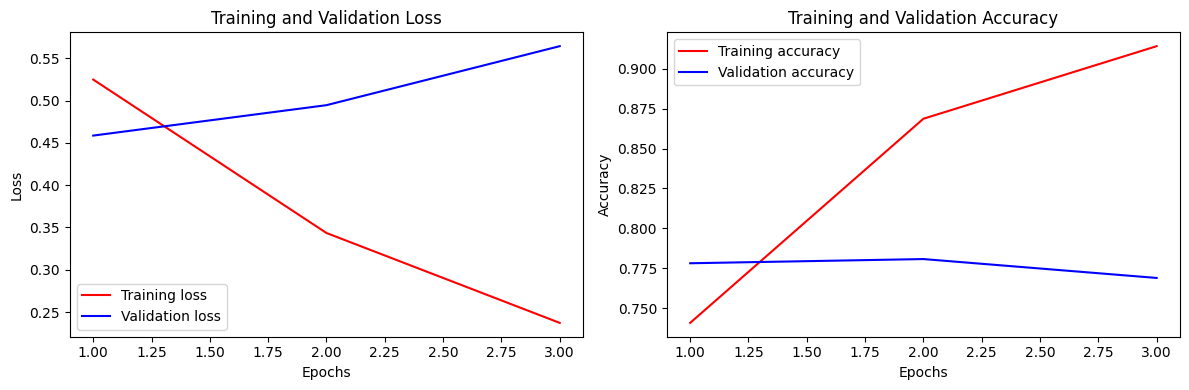

In [49]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_2_history.history['loss']
val_loss = model_2_history.history['val_loss']
train_accuracy = model_2_history.history['accuracy']
val_accuracy = model_2_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 4ms/step


((762, 1),
 array([[0.38058162],
        [0.96276563],
        [0.998811  ],
        [0.13299513],
        [0.04663023],
        [0.99483395],
        [0.9759419 ],
        [0.994655  ],
        [0.9974663 ],
        [0.14753105]], dtype=float32))

In [51]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.9028871391076,
 'precision': 0.7686779209417003,
 'recall': 0.7690288713910761,
 'f1': 0.7684200226242667}

In [53]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


**Model 3: GRU**

In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
#x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
x=tf.keras.layers.Dropout(.5)(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230821-102027
Epoch 1/5
215/215 [==============================] - 14s 53ms/step - loss: 0.5489 - accuracy: 0.7085 - val_loss: 0.4606 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3341 - accuracy: 0.8626 - val_loss: 0.4879 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2269 - accuracy: 0.9145 - val_loss: 0.5515 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1651 - accuracy: 0.9410 - val_loss: 0.6164 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1198 - accuracy: 0.9588 - val_loss: 0.6439 - val_accuracy: 0.7795


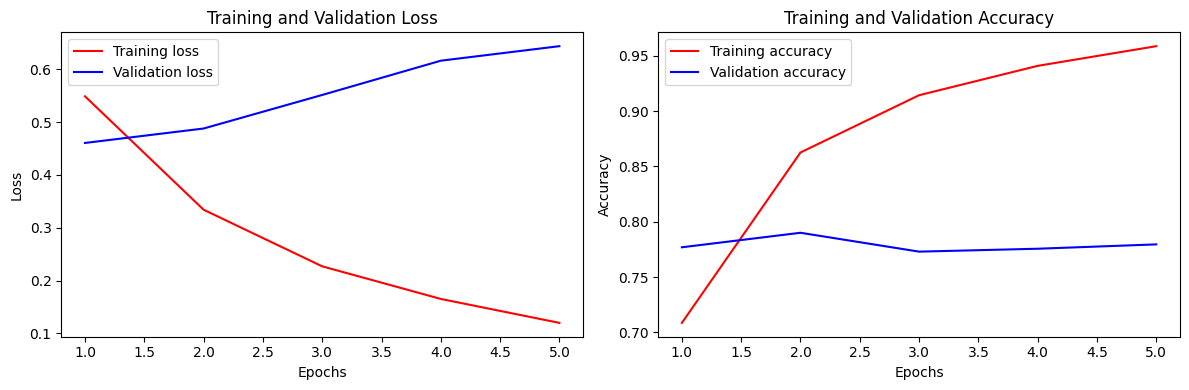

In [55]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_3_history.history['loss']
val_loss = model_3_history.history['val_loss']
train_accuracy = model_3_history.history['accuracy']
val_accuracy = model_3_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.18071948],
        [0.91408306],
        [0.9992047 ],
        [0.11105362],
        [0.00749848],
        [0.99792045],
        [0.86460936],
        [0.9989937 ],
        [0.9989955 ],
        [0.4015071 ]], dtype=float32))

In [57]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.95275590551181,
 'precision': 0.7808713829501961,
 'recall': 0.7795275590551181,
 'f1': 0.7777699173240801}

In [59]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


**Model 4 - Bidirectional LSTM**

In [60]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x=tf.keras.layers.Dropout(.5)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")


# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230821-102055
Epoch 1/5
215/215 [==============================] - 22s 64ms/step - loss: 0.5207 - accuracy: 0.7435 - val_loss: 0.4517 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3246 - accuracy: 0.8717 - val_loss: 0.5143 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2132 - accuracy: 0.9169 - val_loss: 0.5639 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1413 - accuracy: 0.9518 - val_loss: 0.7251 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0909 - accuracy: 0.9634 - val_loss: 0.7801 - val_accuracy: 0.7638


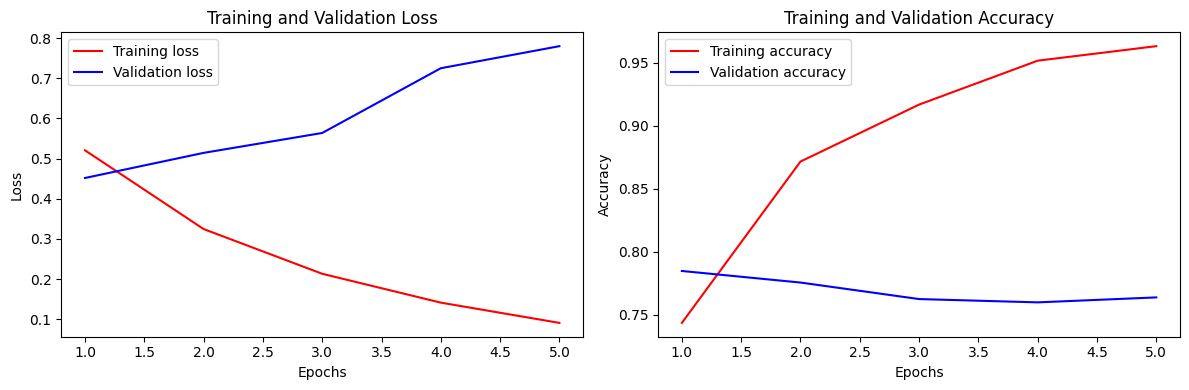

In [61]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_4_history.history['loss']
val_loss = model_4_history.history['val_loss']
train_accuracy = model_4_history.history['accuracy']
val_accuracy = model_4_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.00623518],
       [0.47003272],
       [0.99946755],
       [0.05846042],
       [0.00196213],
       [0.99983096],
       [0.98520005],
       [0.999728  ],
       [0.99950564],
       [0.03789227]], dtype=float32)

In [63]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [64]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7707659441729449,
 'recall': 0.7637795275590551,
 'f1': 0.759231120232152}

In [65]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


**Model 5: Conv1D**

In [66]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [67]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(16, activation="relu")(x) # optional dense layer
x=tf.keras.layers.Dropout(.5)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230821-102146
Epoch 1/5
215/215 [==============================] - 15s 52ms/step - loss: 0.6274 - accuracy: 0.6460 - val_loss: 0.5126 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4133 - accuracy: 0.8356 - val_loss: 0.4776 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2593 - accuracy: 0.9078 - val_loss: 0.5307 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1644 - accuracy: 0.9486 - val_loss: 0.6073 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1146 - accuracy: 0.9631 - val_loss: 0.6719 - val_accuracy: 0.7520


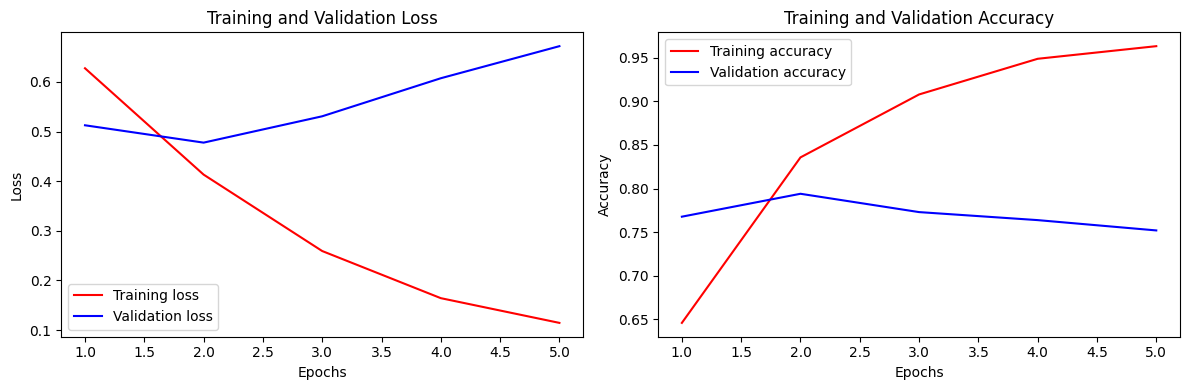

In [68]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_5_history.history['loss']
val_loss = model_5_history.history['val_loss']
train_accuracy = model_5_history.history['accuracy']
val_accuracy = model_5_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.8043365 ],
       [0.9675812 ],
       [0.9997228 ],
       [0.02310681],
       [0.01885228],
       [0.9944524 ],
       [0.9187797 ],
       [0.99793434],
       [0.99733305],
       [0.04912325]], dtype=float32)

In [70]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.19685039370079,
 'precision': 0.7519989531509904,
 'recall': 0.7519685039370079,
 'f1': 0.7505489912204856}

In [72]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.20, Difference: -4.07
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


**Model 6: TensorFlow Hub Pretrained Sentence Encoder**

In [73]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [74]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [75]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230821-102245
Epoch 1/10
215/215 [==============================] - 7s 17ms/step - loss: 0.5056 - accuracy: 0.7830 - val_loss: 0.4468 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 3s 13ms/step - loss: 0.4146 - accuracy: 0.8148 - val_loss: 0.4347 - val_accuracy: 0.8110
Epoch 3/10
215/215 [==============================] - 3s 13ms/step - loss: 0.3997 - accuracy: 0.8225 - val_loss: 0.4307 - val_accuracy: 0.8110
Epoch 4/10
215/215 [==============================] - 4s 18ms/step - loss: 0.3920 - accuracy: 0.8278 - val_loss: 0.4261 - val_accuracy: 0.8136
Epoch 5/10
215/215 [==============================] - 4s 18ms/step - loss: 0.3855 - accuracy: 0.8292 - val_loss: 0.4276 - val_accuracy: 0.8176
Epoch 6/10
215/215 [==============================] - 3s 13ms/step - loss: 0.3784 - accuracy: 0.8330 - val_loss: 0.4225 - val_accuracy: 0.8176
Epoch 7/10
215/215 [==============================] - 3s 1

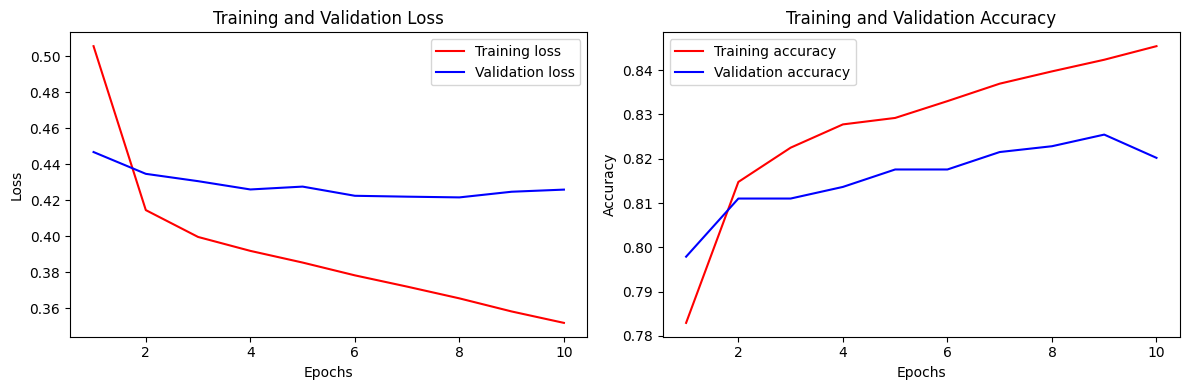

In [76]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_6_history.history['loss']
val_loss = model_6_history.history['val_loss']
train_accuracy = model_6_history.history['accuracy']
val_accuracy = model_6_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.12182128],
       [0.7431165 ],
       [0.99661344],
       [0.22812344],
       [0.60337645],
       [0.7483027 ],
       [0.9833346 ],
       [0.991719  ],
       [0.94281524],
       [0.07298336]], dtype=float32)

In [78]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [79]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 82.02099737532808,
 'precision': 0.8262953138559862,
 'recall': 0.8202099737532809,
 'f1': 0.8177426640567568}

In [80]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 82.02, Difference: 2.76
Baseline precision: 0.81, New precision: 0.83, Difference: 0.02
Baseline recall: 0.79, New recall: 0.82, Difference: 0.03
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


**Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data**

In [81]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [82]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [83]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=10,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230821-102331
Epoch 1/10
22/22 [==============================] - 4s 47ms/step - loss: 0.6676 - accuracy: 0.6749 - val_loss: 0.6496 - val_accuracy: 0.6654
Epoch 2/10
22/22 [==============================] - 1s 28ms/step - loss: 0.5945 - accuracy: 0.7930 - val_loss: 0.5960 - val_accuracy: 0.7283
Epoch 3/10
22/22 [==============================] - 1s 28ms/step - loss: 0.5192 - accuracy: 0.8251 - val_loss: 0.5431 - val_accuracy: 0.7559
Epoch 4/10
22/22 [==============================] - 1s 24ms/step - loss: 0.4555 - accuracy: 0.8324 - val_loss: 0.5105 - val_accuracy: 0.7769
Epoch 5/10
22/22 [==============================] - 1s 36ms/step - loss: 0.4128 - accuracy: 0.8397 - val_loss: 0.4927 - val_accuracy: 0.7822
Epoch 6/10
22/22 [==============================] - 1s 41ms/step - loss: 0.3809 - accuracy: 0.8455 - val_loss: 0.4837 - val_accuracy: 0.7782
Epoch 7/10
22/22 [==============================] - 1s 53ms

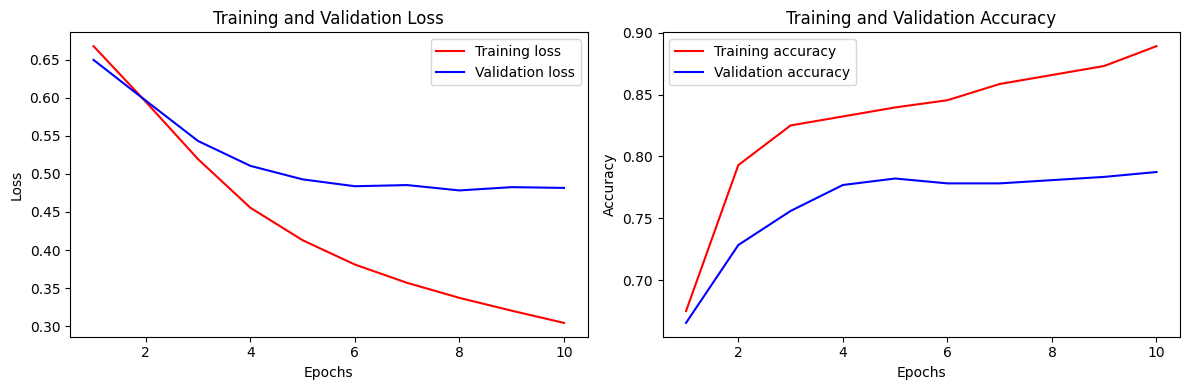

In [84]:
import matplotlib.pyplot as plt

# Eğitim geçmişinden loss ve accuracy değerlerini alın
train_loss = model_7_history.history['loss']
val_loss = model_7_history.history['val_loss']
train_accuracy = model_7_history.history['accuracy']
val_accuracy = model_7_history.history['val_accuracy']

# Epoch sayısı
epochs = range(1, len(train_loss) + 1)

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.17046802],
       [0.9206421 ],
       [0.96584755],
       [0.17234829],
       [0.46749464],
       [0.9079781 ],
       [0.9114758 ],
       [0.9079097 ],
       [0.9005755 ],
       [0.06126144]], dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.74015748031496,
 'precision': 0.7903907506573856,
 'recall': 0.7874015748031497,
 'f1': 0.7850997256765829}

In [88]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


In [89]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.821522,0.780450,0.778215,0.776013
lstm,76.902887,0.768678,0.769029,0.768420
gru,77.952756,0.780871,0.779528,0.777770
bidirectional,76.377953,0.770766,0.763780,0.759231
conv1d,75.196850,0.751999,0.751969,0.750549
tf_hub_sentence_encoder,82.020997,0.826295,0.820210,0.817743
tf_hub_10_percent_data,78.740157,0.790391,0.787402,0.785100


In [90]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

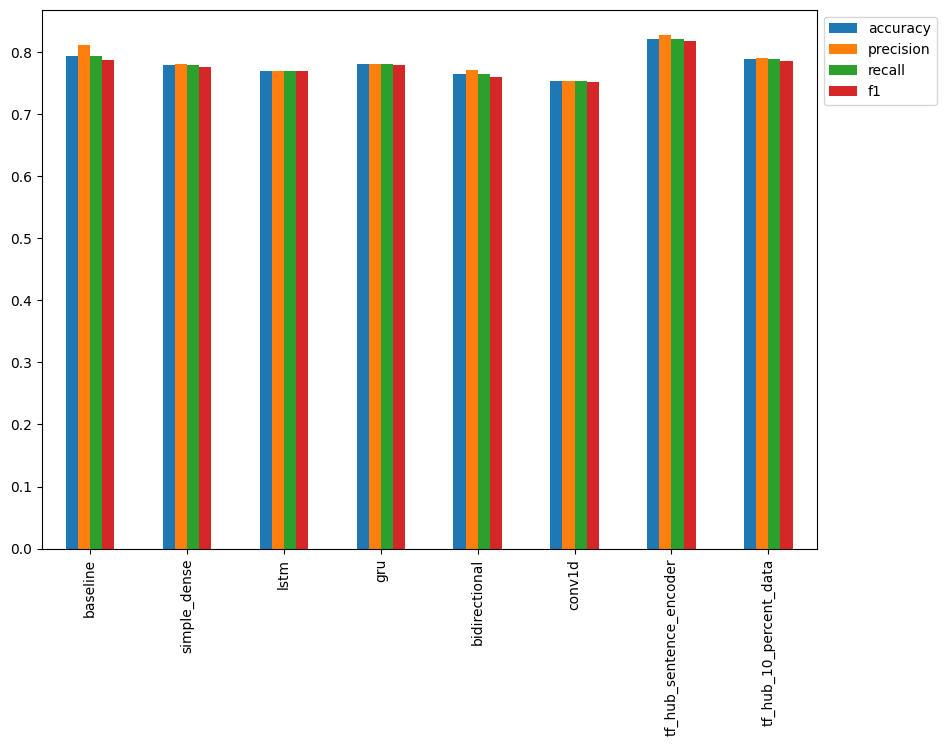

In [91]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

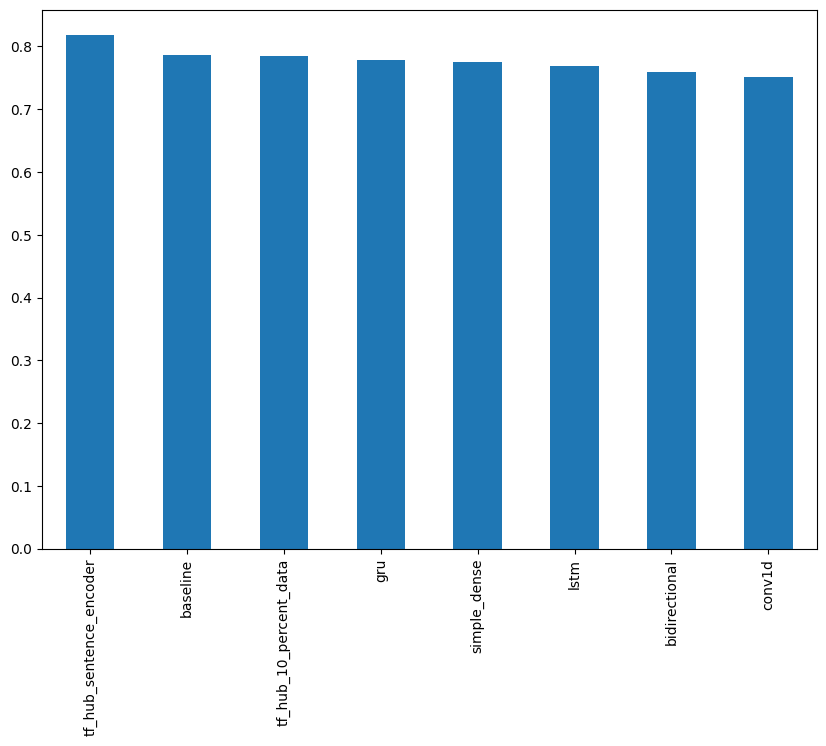

In [92]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

**Saving the Model**

In [93]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [94]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [95]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4260 - accuracy: 0.8202


[0.4259693920612335, 0.8202099800109863]

**Predicting on Tweets from the wild**

In [99]:
# Turn Tweet into string
daniels_tweet = "it was a disaster in New YORK CİTY"

In [97]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [100]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 79ms/step
Pred: 1.0 (real disaster) Prob: 0.7876983880996704
Text:
it was a disaster in New YORK CİTY


In [101]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [102]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 193ms/step
Pred: 1.0 (real disaster) Prob: 0.9859092831611633
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [103]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 65ms/step
Pred: 1.0 (real disaster) Prob: 0.9848682880401611
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


**The speed/score tradeoff**

In [104]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [105]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.3639564209997843, 0.0004776330984249138)

In [106]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.021514198999739165, 2.8233856955038275e-05)

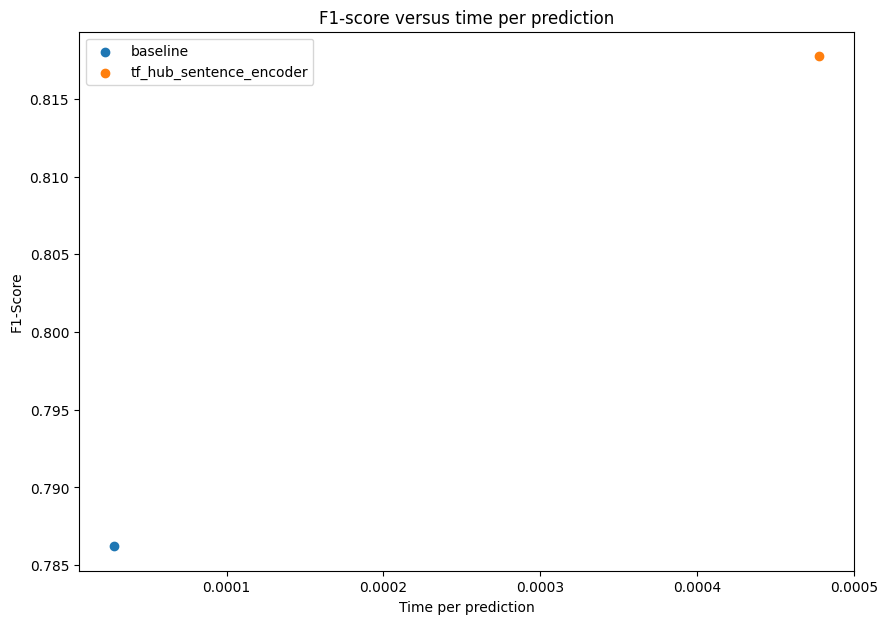

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");